# Weapon detection with YOLOv11

YOLOv11 represents the next step in the evolution of the YOLO (You Only Look Once) object detection series. Building upon the successes of its predecessors, YOLOv11 aims to deliver even better performance in terms of speed, accuracy, and efficiency.

While YOLOv8 is already a strong baseline, the motivation for considering YOLOv11 often lies in potential advancements such as:

- **Improved Accuracy:** YOLOv11 may incorporate new architectural designs or training techniques that lead to higher mean Average Precision (mAP) on challenging datasets.
- **Enhanced Speed and Efficiency:** Newer versions often optimize the model architecture and inference process for faster processing times, crucial for real-time applications.
- **Better Robustness:** YOLOv11 might show improved performance in diverse environments and under various conditions (e.g., different lighting, angles, occlusions).
- **Potentially Smaller Model Size:** Future iterations can sometimes achieve better performance with a reduced number of parameters, making deployment on edge devices more feasible.

Using YOLOv11 for weapon detection in CCTV footage would be motivated by the desire to leverage these potential improvements for more accurate, faster, and reliable identification of threats in real-time surveillance scenarios.

In [1]:
import os
import glob
from pathlib import Path

# Assuming the images and annotations are in subdirectories like 'images' and 'labels'
# within the downloaded dataset path.
image_files = glob.glob('Dataset/images/**/*.png', recursive=True)
label_files = glob.glob('Dataset/labels/**/*.txt', recursive=True)

# Create a list of tuples (image_path, label_path)
image_annotation_pairs = []
for img_path in image_files:
    # Construct the corresponding label file path by replacing 'images' with 'labels' and changing the extension to '.txt'
    label_path = Path(str(img_path).replace('images', 'labels')).with_suffix('.txt')
    if label_path.exists():
        image_annotation_pairs.append((img_path, str(label_path)))

print(f"Found {len(image_annotation_pairs)} image and annotation pairs.")

# Print the first few pairs as examples
print("\nSample image and annotation pairs:")
for img_path, label_path in image_annotation_pairs[:5]:
    print(f"Image: {img_path}, Annotation: {label_path}")

Found 141 image and annotation pairs.

Sample image and annotation pairs:
Image: Dataset/images/Scene5_4.png, Annotation: Dataset/labels/Scene5_4.txt
Image: Dataset/images/Scene4_1.png, Annotation: Dataset/labels/Scene4_1.txt
Image: Dataset/images/Scene3_22.png, Annotation: Dataset/labels/Scene3_22.txt
Image: Dataset/images/Scene3_31.png, Annotation: Dataset/labels/Scene3_31.txt
Image: Dataset/images/Scene6_4.png, Annotation: Dataset/labels/Scene6_4.txt


## Load and parse data

Read the image and annotation files from the `image_annotation_pairs` list. Parse the YOLO format annotations to get the bounding box coordinates and class labels.

In [2]:
image_annotation_pairs

[('Dataset/images/Scene5_4.png', 'Dataset/labels/Scene5_4.txt'),
 ('Dataset/images/Scene4_1.png', 'Dataset/labels/Scene4_1.txt'),
 ('Dataset/images/Scene3_22.png', 'Dataset/labels/Scene3_22.txt'),
 ('Dataset/images/Scene3_31.png', 'Dataset/labels/Scene3_31.txt'),
 ('Dataset/images/Scene6_4.png', 'Dataset/labels/Scene6_4.txt'),
 ('Dataset/images/Scene2_17.png', 'Dataset/labels/Scene2_17.txt'),
 ('Dataset/images/Scene3_3.png', 'Dataset/labels/Scene3_3.txt'),
 ('Dataset/images/Scene2_1.png', 'Dataset/labels/Scene2_1.txt'),
 ('Dataset/images/Scene4_14.png', 'Dataset/labels/Scene4_14.txt'),
 ('Dataset/images/Scene5_7.png', 'Dataset/labels/Scene5_7.txt'),
 ('Dataset/images/Scene6_11.png', 'Dataset/labels/Scene6_11.txt'),
 ('Dataset/images/Scene2_2.png', 'Dataset/labels/Scene2_2.txt'),
 ('Dataset/images/Scene1_7.png', 'Dataset/labels/Scene1_7.txt'),
 ('Dataset/images/Scene6_13.png', 'Dataset/labels/Scene6_13.txt'),
 ('Dataset/images/Scene3_24.png', 'Dataset/labels/Scene3_24.txt'),
 ('Dataset/

In [3]:
import cv2
import numpy as np

# List to store the parsed data
parsed_data = []

for img_path, label_path in image_annotation_pairs:
    # Read the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    height, width, _ = image.shape

    # Read the annotation file
    annotations = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                # YOLO format: center_x, center_y, width, height (normalized)
                center_x, center_y, bbox_width_norm, bbox_height_norm = map(float, parts[1:])

                # Convert normalized coordinates to absolute pixel coordinates (top-left x, top-left y, width, height)
                bbox_width_abs = bbox_width_norm * width
                bbox_height_abs = bbox_height_norm * height
                top_left_x = (center_x * width) - (bbox_width_abs / 2)
                top_left_y = (center_y * height) - (bbox_height_abs / 2)

                annotations.append({
                    'class_id': class_id,
                    'bbox': (int(top_left_x), int(top_left_y), int(bbox_width_abs), int(bbox_height_abs))
                })
            else:
                print(f"Warning: Skipping invalid line in {label_path}: {line.strip()}")

    parsed_data.append({
        'image': image,
        'annotations': annotations,
        'image_path': img_path
    })

print(f"Successfully parsed annotations for {len(parsed_data)} images.")

Successfully parsed annotations for 141 images.


## Visualize images with annotations

Display a grid of images with the parsed bounding boxes and labels drawn on them.

In [4]:
# Define specific colors for classes 0 and 1
class_colors = {
    0: 'yellow',
    1: 'red'
}

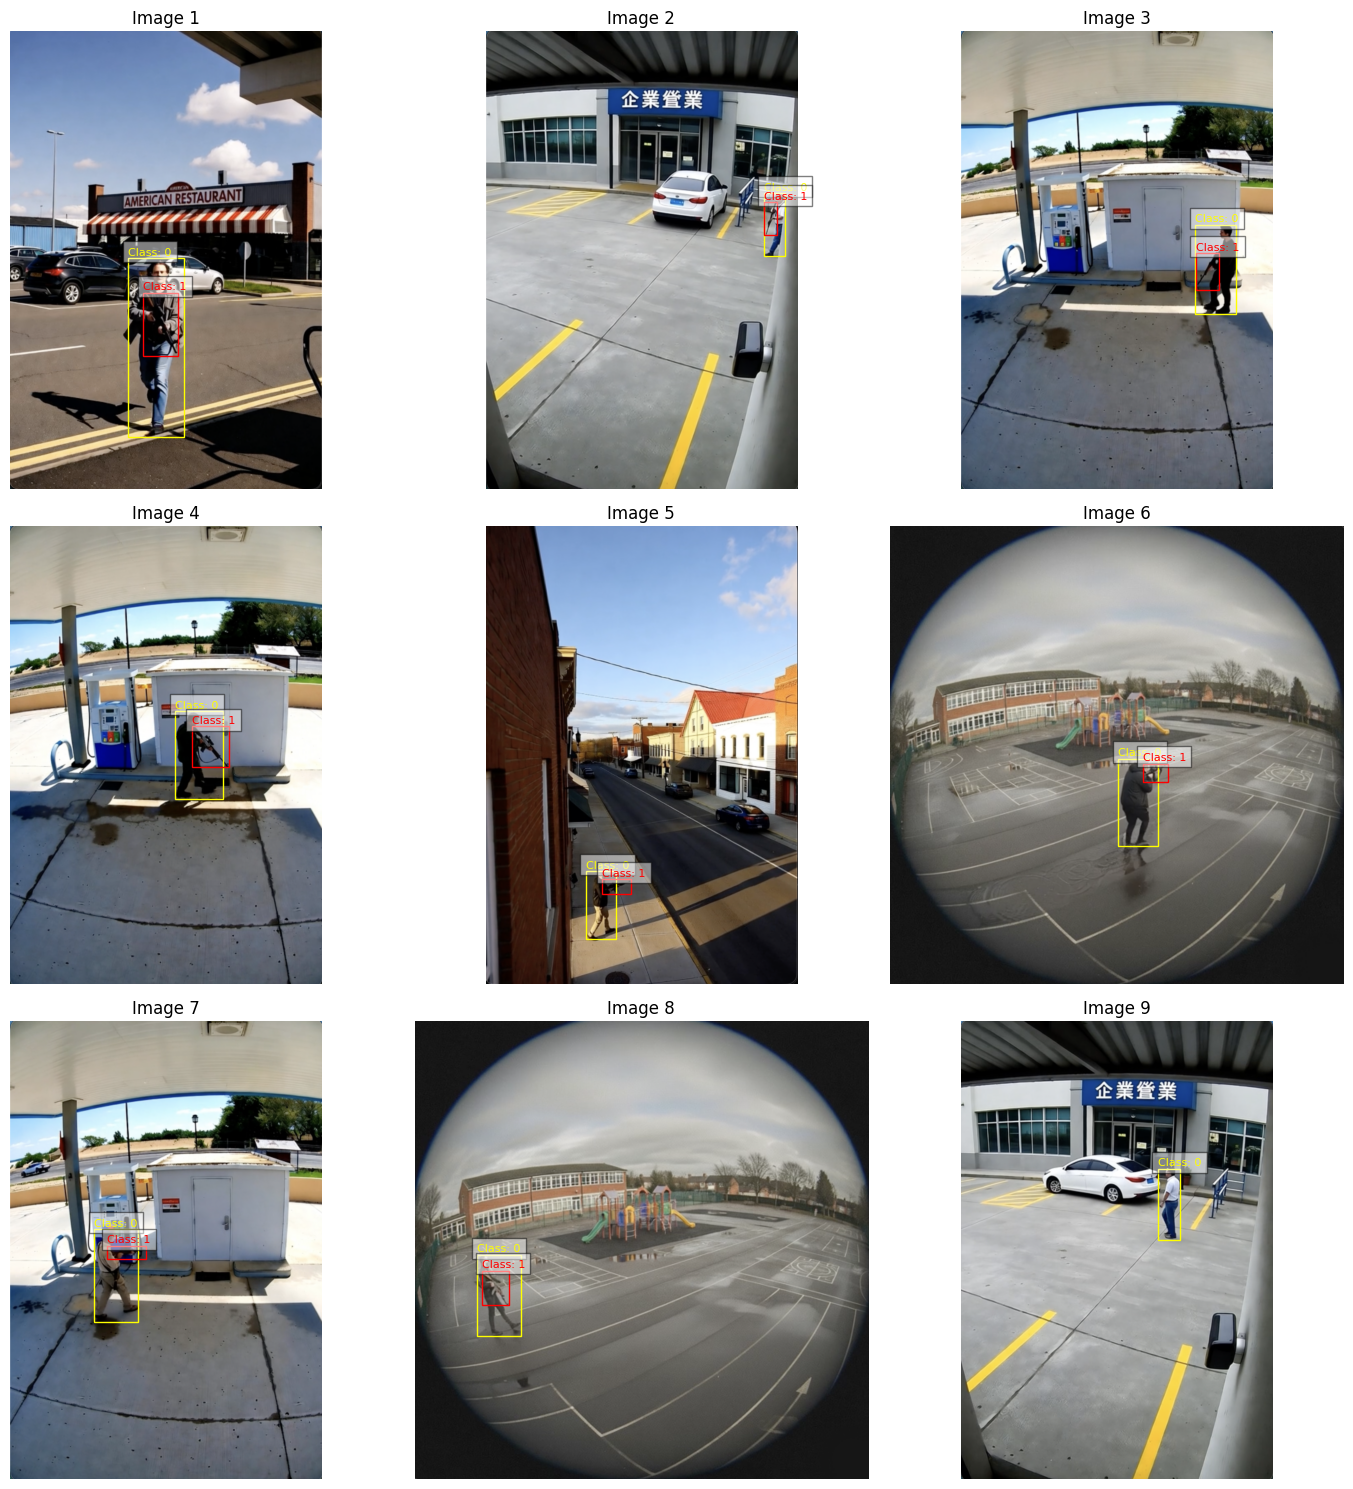

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the number of images to display and the grid layout
n_images_to_display = 9  # Display the first 9 images
n_cols = 3
n_rows = (n_images_to_display + n_cols - 1) // n_cols # Calculate rows needed
# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the first n_images_to_display items in the parsed_data list
for i in range(min(n_images_to_display, len(parsed_data))):
    data = parsed_data[i]
    image = data['image']
    annotations = data['annotations']

    # Convert the image from BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(image_rgb)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

    # Draw bounding boxes and labels
    for annotation in annotations:
        class_id = annotation['class_id']
        x, y, w, h = annotation['bbox']
        # Get the color for the current class, default to a color if not in class_colors
        color = class_colors.get(class_id, 'blue') # Use blue for other classes
        # Create a Rectangle patch
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor='none')
        # Add the patch to the Axes
        axes[i].add_patch(rect)
        # Add class ID as text
        axes[i].text(x, y - 10, f'Class: {class_id}', color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Create yaml file

Generate the dataset.yaml file with the defined paths and class names in the required YOLO format.


Define the class names based on the dataset's content.
From the previous visualization, we saw class_id 0 and 1.
We need to determine what these class IDs represent. Without explicit class mapping information, we will make an educated guess or use generic names.
A common convention for weapon detection might be something like 'gun' or 'weapon'.
Let's assume class 0 is 'weapon' and class 1 is 'person' (or vice versa), or just generic names.
Since the dataset is "cctv-weapon-dataset", class 0 is likely 'weapon'.
We need to be careful if there are other classes. Based on the visualization showing class_id 0 and 1, let's assume there are two classes. We'll need to confirm the actual class names if possible.

Let's assume based on the dataset name and common object detection classes:
- **Class 0**: 'weapon'
- **Class 1**: 'person' # Assuming class 0 is 'weapon' and class 1 is 'person'

In [6]:
import yaml

class_names = ['person', 'weapon']

# Create a Python dictionary containing the dataset information.
dataset_info = {
    'path': 'Dataset', # Base path to the dataset directory
    'train': 'images',       # Relative path from 'path' to the training images
    'val': 'images',         # Relative path from 'path' to the validation images
    'nc': len(class_names),  # Number of classes
    'names': class_names     # List of class names
}

# Define the filename for the YAML file
yaml_filename = 'dataset.yaml'

# Open the specified filename in write mode ('w') and Use a YAML library to dump the dictionary
with open(yaml_filename, 'w') as f:
    yaml.dump(dataset_info, f, default_flow_style=None)

# Print a confirmation message
print(f"Dataset YAML file '{yaml_filename}' created successfully.")

Dataset YAML file 'dataset.yaml' created successfully.


## Train YOLO Model

This cell uses the Ultralytics library to train a YOLO object detection model on your dataset.

- It first loads a pretrained `yolov8s.pt` model.
- Then, it starts the training process using the `model.train()` method.
    - `data='dataset.yaml'` specifies the path to the dataset configuration file we created.
    - `epochs=10` sets the number of training iterations.
    - `imgsz=640` sets the input image size for training.

The training results will be saved in the `runs/detect/train` directory by default.

In [7]:
from ultralytics import YOLO

# Load a pretrained YOLOv8s model
# You can choose other models like 'yolov8n.pt', 'yolov8m.pt', etc.
model = YOLO('best.pt')

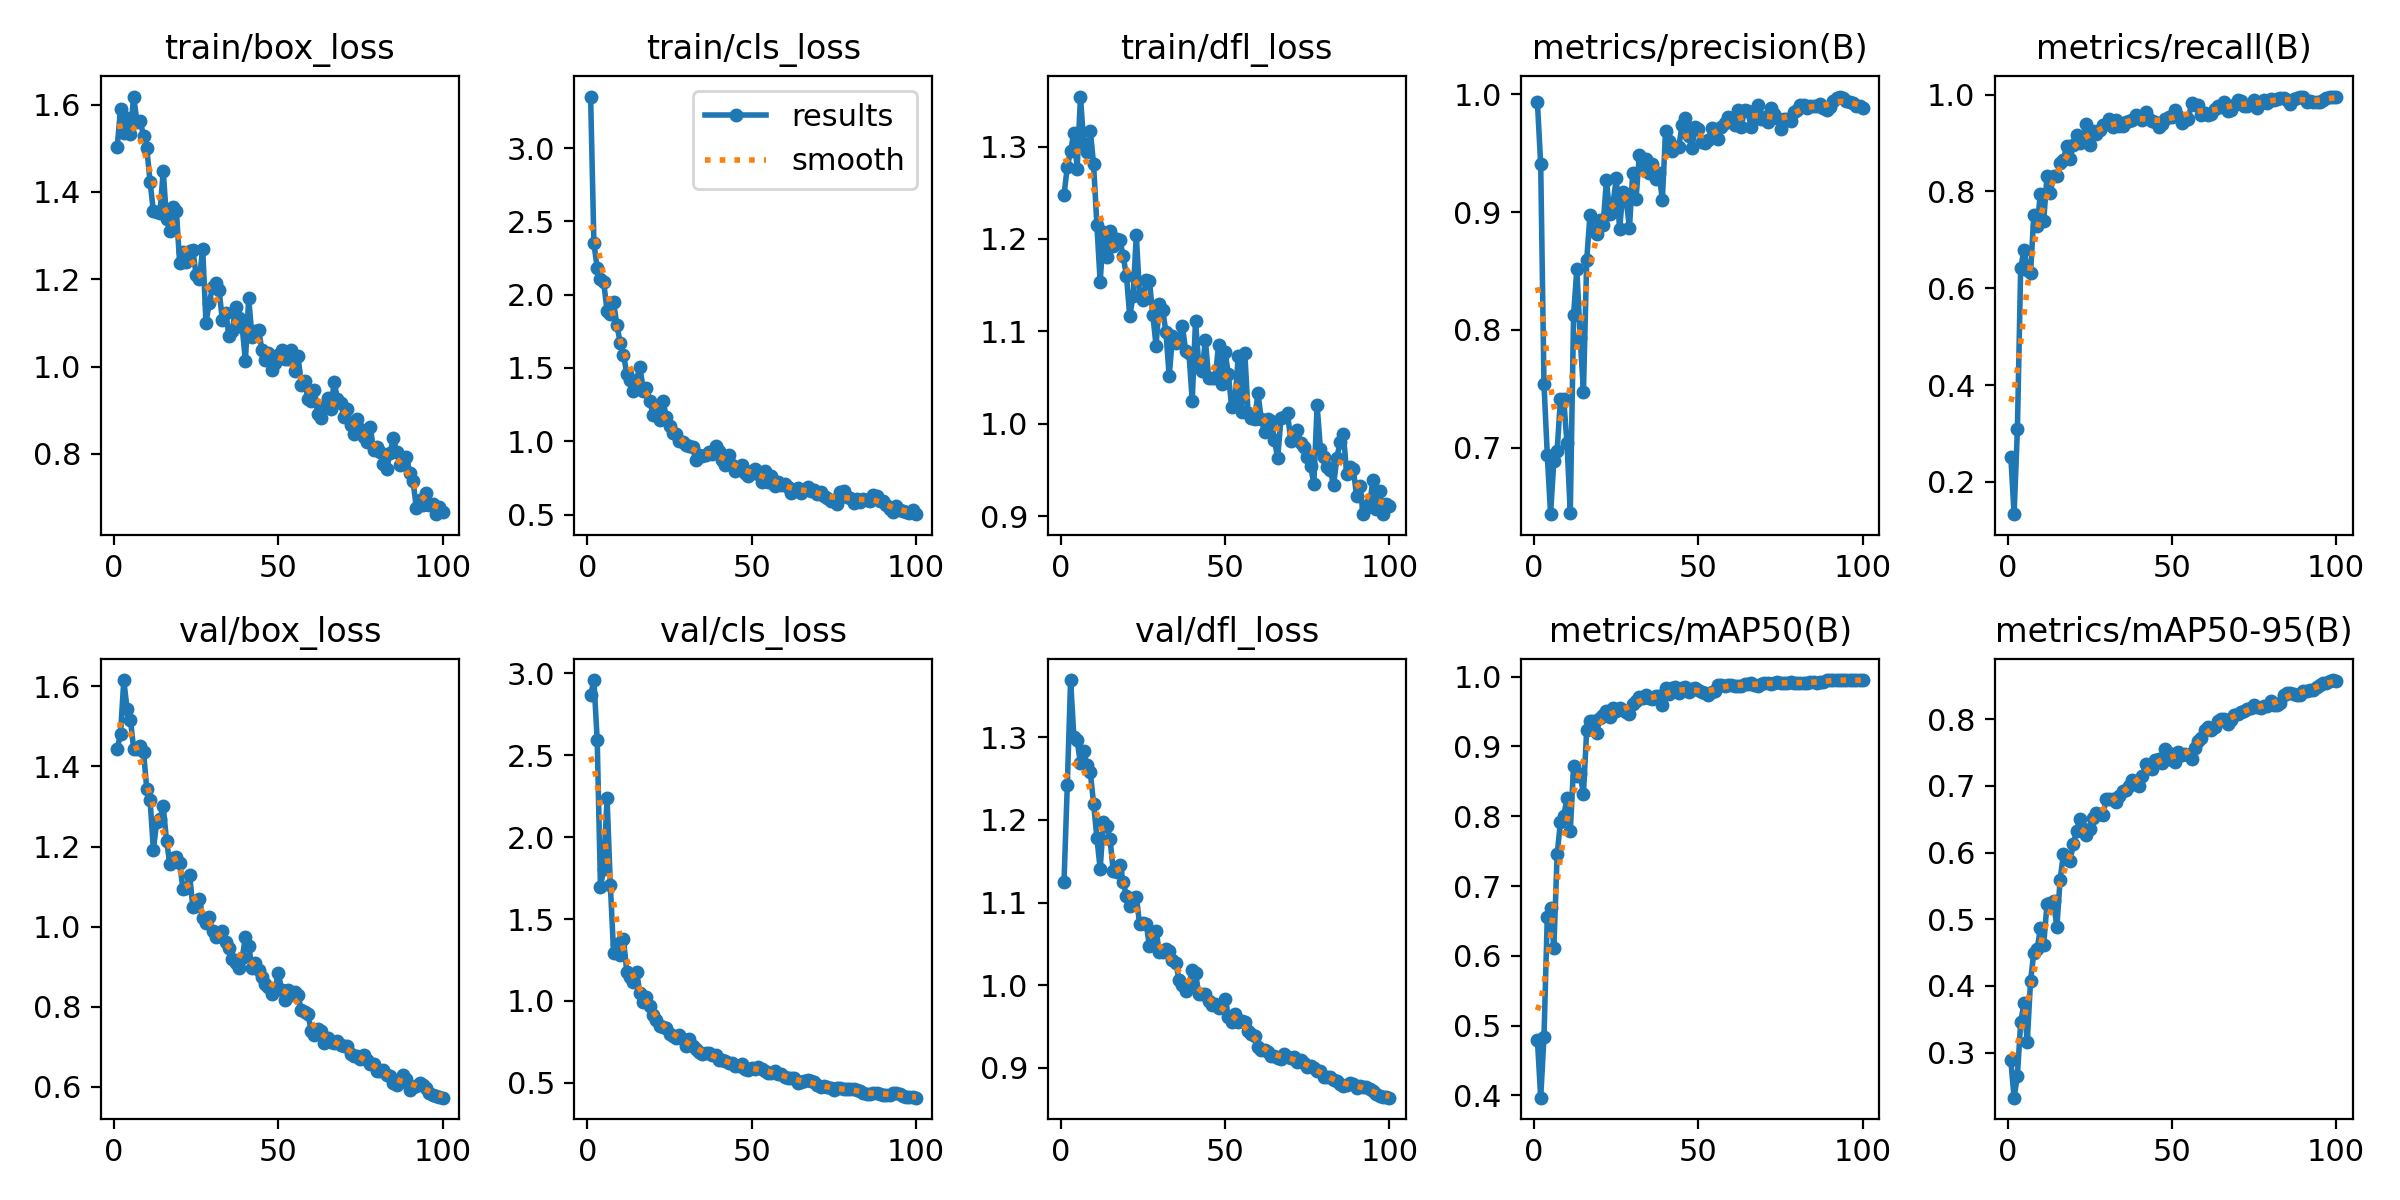

In [8]:
from IPython.display import Image, display

# Find the latest training run directory
runs_dir = 'runs/detect'
latest_run_dir = max(glob.glob(f'{runs_dir}/train*'), key=os.path.getctime)

# Path to the results plot
results_plot_path = f'{latest_run_dir}/results.png'
display(Image(filename=results_plot_path))

In [9]:
# You can also run validation after training
results = model.val()

# Display key validation metrics in a human-readable format
print("\nValidation Metrics:")
print(f"  mAP50-95: {results.box.map:.4f}")
print(f"  mAP50: {results.box.map50:.4f}")
print(f"  Precision: {results.box.p.mean():.4f}")
print(f"  Recall: {results.box.r.mean():.4f}")

# Print metrics per class if available
if results.box.ap_class_index is not None and results.box.ap is not None:
    print("\nMetrics per Class:")
    for i, class_index in enumerate(results.box.ap_class_index):
        class_name = model.names[class_index]
        print(f"  Class '{class_name}' (ID {class_index}):")
        print(f"    AP50-95: {results.box.ap[i]:.4f}")
        print(f"    AP50: {results.box.ap50[i]:.4f}")
        print(f"    Precision: {results.box.p[i]:.4f}")
        print(f"    Recall: {results.box.r[i]:.4f}")

Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.7.1+cu128 CUDA:0 (NVIDIA RTX A1000 Laptop GPU, 3904MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7568.5±4394.7 MB/s, size: 1522.1 KB)
val: Scanning /home/dev/PycharmProjects/gun_detection/Dataset/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 141/141 423.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 5.3it/s 1.7s0.1s
                   all        141        269       0.99      0.996      0.995      0.858
                person        139        139       0.98          1      0.995      0.907
                weapon        130        130      0.999      0.992      0.995      0.809
Speed: 1.6ms preprocess, 5.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /home/dev/PycharmProjects/gun_detection/runs/detect/val2

Validation Metrics:
 

## Run inference with trained detector

Run inference on sample images or a directory of images.
You can replace 'path/to/your/sample/images' with the actual path to your images.
For example, you can use a few images from the validation set if you have one, or select a few images from the original dataset.

Let's use a few images from the original dataset for demonstration.

In [10]:
# Find the latest training run directory
runs_dir = 'runs/detect'
latest_run_dir = max(glob.glob(f'{runs_dir}/train*'), key=os.path.getctime)

# Load the trained model
# The trained model is typically saved in runs/detect/train/weights/best.pt after training
#trained_model_path = f'{latest_run_dir}/weights/best.pt' # Adjust path if necessary
#model = YOLO(trained_model_path)

# Get a list of sample image paths (e.g., the first 9 images from the original list for a 3x3 grid)
n_images_to_display = 9
sample_image_paths = [img_path for img_path, _ in image_annotation_pairs[:n_images_to_display]]

# Run prediction
results = model.predict(source=sample_image_paths, conf=0.25, iou=0.7) # Adjust confidence and iou thresholds as needed


0: 640x640 1 person, 1 weapon, 4.8ms
1: 640x640 1 person, 1 weapon, 4.8ms
2: 640x640 1 person, 1 weapon, 4.8ms
3: 640x640 1 person, 1 weapon, 4.8ms
4: 640x640 1 person, 1 weapon, 4.8ms
5: 640x640 1 person, 1 weapon, 4.8ms
6: 640x640 1 person, 1 weapon, 4.8ms
7: 640x640 1 person, 1 weapon, 4.8ms
8: 640x640 1 person, 1 weapon, 4.8ms
Speed: 1.5ms preprocess, 4.8ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


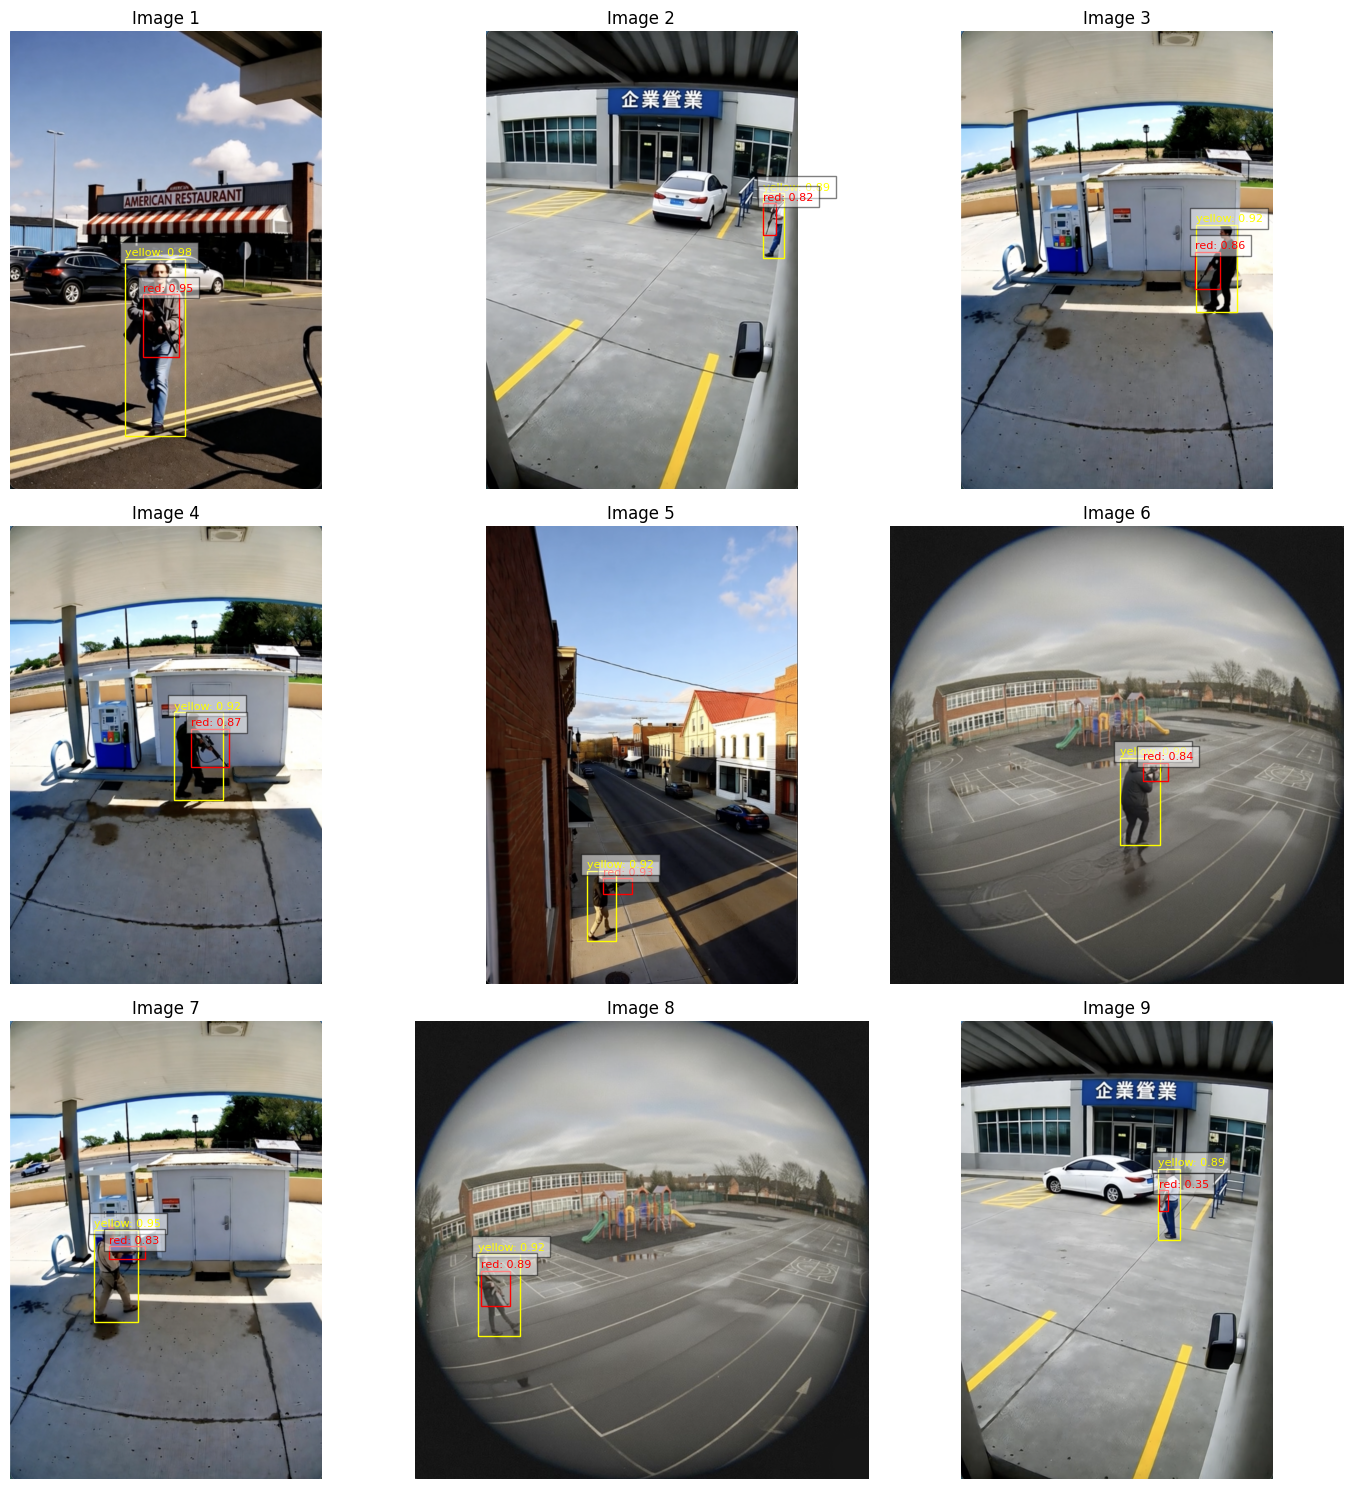

In [11]:
# Define the grid layout
n_cols = 3
n_rows = (n_images_to_display + n_cols - 1) // n_cols
# Create a figure and a set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
# Flatten the axes array for easy iteration
axes = axes.flatten()

# Process and display results in a grid
for i, result in enumerate(results):
    # Get the original image (Ultralytics returns the image as a numpy array)
    image = result.orig_img

    # Convert the image from BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    axes[i].imshow(image_rgb)
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

    # Draw bounding boxes and labels
    if result.boxes is not None:
        for box in result.boxes:
            # Get box coordinates in xyxy format
            xyxy = box.xyxy[0].cpu().numpy()
            x1, y1, x2, y2 = xyxy
            # Get class ID and confidence
            class_id = int(box.cls[0].cpu().numpy())
            confidence = box.conf[0].cpu().numpy()
            # Get the color for the current class
            color = class_colors.get(class_id, 'blue') # Use blue for other classes
            # Create a Rectangle patch (convert xyxy to x, y, w, h format)
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor=color, facecolor='none')
            # Add the patch to the Axes
            axes[i].add_patch(rect)
            # Add class label and confidence as text
            label = f'{class_colors.get(class_id, f"Class: {class_id}")}: {confidence:.2f}'
            axes[i].text(x1, y1 - 10, label, color=color, fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [33]:
import torch
torchmodel = torch.jit.load("best.torchscript", map_location='cuda')
torchmodel.eval()

RecursiveScriptModule(
  original_name=DetectionModel
  (model): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(
      original_name=Conv
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (act): RecursiveScriptModule(original_name=SiLU)
    )
    (1): RecursiveScriptModule(
      original_name=Conv
      (conv): RecursiveScriptModule(original_name=Conv2d)
      (act): RecursiveScriptModule(original_name=SiLU)
    )
    (2): RecursiveScriptModule(
      original_name=C2f
      (cv1): RecursiveScriptModule(
        original_name=Conv
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (act): RecursiveScriptModule(original_name=SiLU)
      )
      (cv2): RecursiveScriptModule(
        original_name=Conv
        (conv): RecursiveScriptModule(original_name=Conv2d)
        (act): RecursiveScriptModule(original_name=SiLU)
      )
      (m): RecursiveScriptModule(
        original_name=ModuleList
        (0): RecursiveScriptModu

In [66]:
def preprocess_image(image_ori) -> torch.Tensor:
    image = cv2.resize(image_ori, (640, 640))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = torch.from_numpy(image_rgb).float()
    image_tensor = image_tensor.permute(2, 0, 1)  # Change from HWC to CHW format
    image_tensor = image_tensor / 255.0  # Normalize to [0, 1]
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor, image_rgb

cv2_img = cv2.imread("Dataset/images/Scene5_4.png")
image, image_rgb = preprocess_image(cv2_img)
image = image.cuda()


In [69]:
result = results[0]  # Remove the batch dimension if there's only one image
boxes = result[:4,:]
person_prob = torch.argmax(result[4])
gun_prob = torch.argmax(result[5])
box_np = boxes[:,gun_prob].cpu().numpy() if boxes[:,gun_prob].is_cuda else boxes[:,gun_prob].numpy()
x, y, w, h = box_np
x1 = int((x - w / 2))
y1 = int((y - h / 2))
x2 = int(x1 + w)
y2 = int(y1 + h)

np.float32(311.00494)

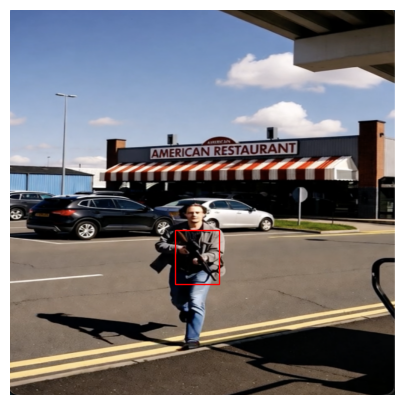

In [70]:
fig, axes = plt.subplots(1, figsize=(15, 5))
axes.imshow(image_rgb)
axes.axis('off')
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='red', facecolor='none')
axes.add_patch(rect)